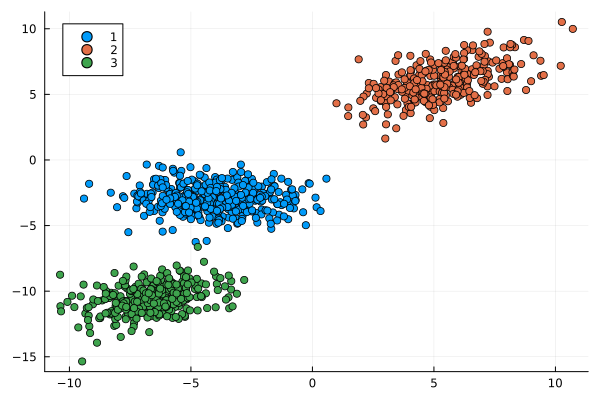

In [1]:
using Plots, CluGen
o = clugen(2, 3, 1000, [1, 1], pi / 8, [10, 10], 10, 2, 1)
p = plot(o.points[:, 1], o.points[:, 2], seriestype = :scatter, group=o.clusters)

In [2]:
data = collect(o.points')

2×1000 Matrix{Float64}:
 -4.16896  -5.48215  -2.44547  -3.47892  …   -8.09347   -3.98192   -5.17023
 -3.70214  -1.74955  -1.82283  -5.19141     -10.8917   -11.2279   -10.1476

## Algorithm

1. Initialise the k centroids by picking k points randomly from our dataset.
2. Check each points’ distance from the centroids and assign each point to the closest cluster centroid.
3. Calculate the average of all points per clusters and move the cluster centroids to these points.
4. Go to number 2, iterate until the centroids stop moving.


Reference [Bence Komarniczky - K-means from scratch in Julia]( https://niczky12.medium.com/k-means-from-scratch-in-julia-e5f43e023154)

In order to improve the computation we will restart iterations for differents initial centroids. To select the best result we need a cost function defined as the summation of euclidean distance of each training example with its cluster center and this is summed over k clusters.
$$
J = \sum_{j=1}^{k} \sum_{i=1}^{m} a_{ij} || x_i - \mu_j ||_2^2
$$
if $x_i \in c_j$ $ a_{ij} = 1$ else $ a_{ij} = 0 $

In [3]:
function euclidean(a::AbstractVector{T}, b::AbstractVector{T}) where {T<:AbstractFloat}

    s = zero(T)
    for i in eachindex(a)
        s += (a[i] - b[i])^2
    end
    return sqrt(s)

end

euclidean (generic function with 1 method)

In [9]:
using StatsBase

function initialize_centers(data, k) 
    n = size(data, 1)
    return [data[i, :] for i in sample(1:n, k, replace=false)]
end

initialize_centers (generic function with 1 method)

In [10]:
function update_labels!( labels, data, centers)

    for (i, obs) in enumerate(eachrow(data))
        dist = [euclidean(obs, c) for c in centers]
        labels[i] = argmin(dist)
    end

end

update_labels! (generic function with 1 method)

In [12]:
function update_centers!(centers, data, labels)
    
    for k in eachindex(centers)
        centers[k] = vec(mean(view(data, labels .== k, :), dims = 1))
    end

end


update_centers! (generic function with 1 method)

In [13]:
function compute_inertia(centers, labels, data)
   inertia = 0.0
   for k in eachindex(centers)
       cluster = view(data, labels .== k, :)
       inertia += sum(euclidean(p, centers[k])^2 for p in eachrow(cluster))
   end
   return inertia
end

compute_inertia (generic function with 1 method)

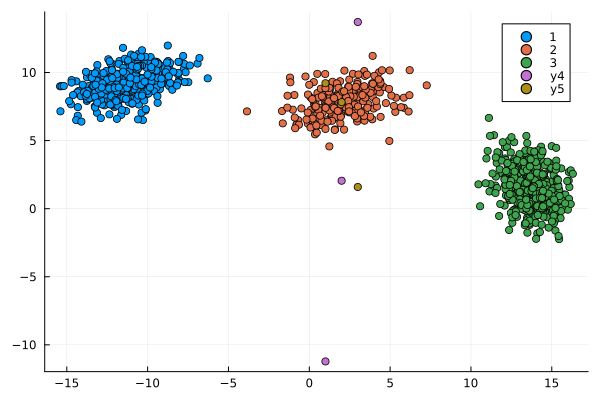

In [16]:
function kmeans( data, k; maxiter = 100, nstart = 10)

    n, d = size(data)
    opt_centers = [zeros(d) for i in 1:k]  # allocate optimal centers
    labels = zeros(Int, n) # initialize labels
    opt_inertia = Inf
    for istart in 1:nstart
        centers = initialize_centers(data, k)
        for istep in 1:maxiter
            old_centers = deepcopy(centers)
            update_labels!( labels, data, centers)
            update_centers!(centers, data, labels)
            centers ≈ old_centers && break
        end
        inertia = compute_inertia(centers, labels, data)
        if inertia < opt_inertia
            opt_inertia = inertia
            opt_centers .= deepcopy(centers)
        end
    end
    update_labels!( labels, data, opt_centers)
    return opt_centers, labels

end

using Plots, CluGen
o = clugen(2, 3, 1000, [1, 1], pi / 8, [10, 10], 10, 2, 1)
centers, labels = kmeans(o.points, 3)
scatter( o.points[:,1], o.points[:,2], group=labels)


In [26]:
function kmeans_simple(X, k, max_iter = 100, nstart = 10, threshold = 0.01)
    
    d, n = size(X)
    
    centroids_opt = zeros(d, k)
    cost_max = Inf
    cost = 0
    
    # This will hold the cluster assignment for each point in X
    labels = zeros(Int, n)
    
    for istart in 1:nstart
        
        # Let's pick k points from X without replacement
        centroids = X[:, sample(1:n, k, replace = false)]
    
        # create a copy. This is used to check if the centroids are moving or not.
        new_centroids = similar(centroids)
    
        for _ in 1:max_iter
            
            intertia = 0.0
            
            for col_idx in 1:n # iterate over each point
    
                p = view(X,:, col_idx)
    
                # distance between the point and each centroid
                point_difference = mapslices(x -> x .- p, centroids, dims=1)
    
                # squared Euclidian distance
                distances = mapslices(sum, point_difference .^ 2, dims=1)
    
                # index of the closest centroid
                labels[col_idx] = findmin(distances)[2][2]
                
            end
    
    
            # Iterate over each centroid
            cost = 0
            for label in 1:k
                # find the mean of the assigned points for that particular cluster
                mask = [i for (i, m) in enumerate(label .== labels) if m]
                new_centroids[:, label] = mapslices(mean, X[:, mask], dims=2)
                cost += sum(mapslices(x -> sum(x.^2), 
                            X[:, mask] .- new_centroids[:, label], dims=2))
            end
            
            # if the centroids move negligably, then we're done
            if isapprox(centroids, new_centroids; rtol=threshold)
                 break
            else
                centroids .= new_centroids
            end
        end
        
        if cost < cost_max
            centroids_opt .= centroids
            cost_max = cost
        end
            
        
    end
    
    return centroids_opt, labels, cost_max
end

kmeans_simple (generic function with 4 methods)

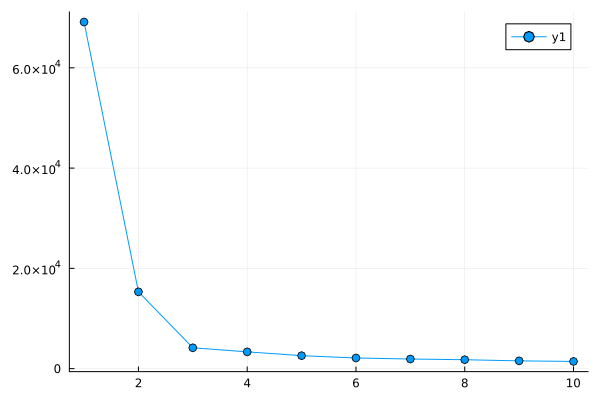

In [27]:
costs = Float64[]
for k in 1:10
    
    centers, labels, cost = kmeans_simple(data, k)
    push!(costs, cost)
    
end

plot(costs, marker=:o)

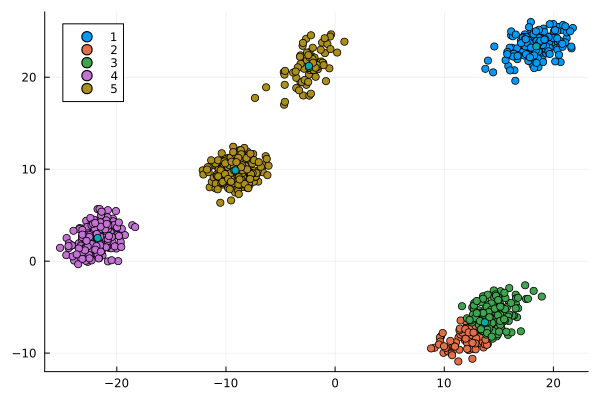

In [80]:
centers, labels, cost = kmeans_simple(data, 5)

# draw original points
scatter(data[1, :], data[2, :], group=labels)
# draw the centroids
scatter!(centers[1, :], centers[2, :], label = "")